In [1]:

!pip install protobuf==3.20.3



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

## 1. Import Libraries and Set Configurations
Importing necessary libraries for image processing, model building, and visualization. We also configure the device settings.

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

# Filter warnings for a cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Dataset Paths
images_path = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/frames' 
masks_path = '/kaggle/input/covid19-ct-scan-lesion-segmentation-dataset/masks'   

# Image Dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3

2025-12-17 18:26:26.295686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765995986.762595      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765995986.871020      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load and Preprocess Data
Reading images and masks, resizing them to 128x128, and normalizing pixel values. Masks are converted to binary (0 and 1).

In [3]:
images = []
masks = []

# Sorting ensures that image number 1 corresponds to mask number 1
# If the order differs, the model training will be incorrect
img_filenames = sorted(os.listdir(images_path))
mask_filenames = sorted(os.listdir(masks_path))


for i, file_name in enumerate(img_filenames):
    # Read the image
    img_path = os.path.join(images_path, file_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) # Resize to standard dimensions
    img = img / 255.0  # Normalization: scale values between 0 and 1
    images.append(img)
    
    # Read the corresponding mask
    # We assume here that the mask has the same name or index order
    mask_name = mask_filenames[i] 
    mask_path = os.path.join(masks_path, mask_name)
    mask = cv2.imread(mask_path, 0) # 0 means read as grayscale
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    
    # Convert the mask to Binary (0 and 1 only)
    # Any pixel with a value greater than 127 is considered a lesion (1), others background (0)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    mask = mask / 255.0  # Normalization
    mask = np.expand_dims(mask, axis=-1) # Expand dims so shape becomes (128, 128, 1)
    masks.append(mask)

X = np.array(images)
Y = np.array(masks)

print(f"Data Loaded. Images: {X.shape}, Masks: {Y.shape}")

Data Loaded. Images: (2729, 128, 128, 3), Masks: (2729, 128, 128, 1)


## 3. Split Data into Train, Validation, and Test
We split the dataset into three parts: 80% Training, 10% Validation, and 10% Testing.

In [4]:
# First split: Take 80% for training and hold out 20% temporarily
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)

# Second split: The 20% we set aside (temp), we will split in half
# Half for Validation and half for Test
# test_size=0.5 means split this amount into two equal halves
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (2183, 128, 128, 3)
Validation Data: (273, 128, 128, 3)
Testing Data: (273, 128, 128, 3)


## 4. Setup Data Augmentation
Using `ImageDataGenerator` to artificially increase the size of the training set by applying transformations like rotation, shift, and zoom.

In [5]:
# Define augmentation arguments
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Create generators for images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# We must use the same seed to ensure the image and its mask are transformed identically
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Function to combine generators
def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

# Final training generator
train_generator = combine_generator(
    image_datagen.flow(X_train, batch_size=16, seed=seed),
    mask_datagen.flow(y_train, batch_size=16, seed=seed))

## 5. Visualize Data Augmentation
Demonstrating the effect of augmentation on a single sample to ensure correctness.

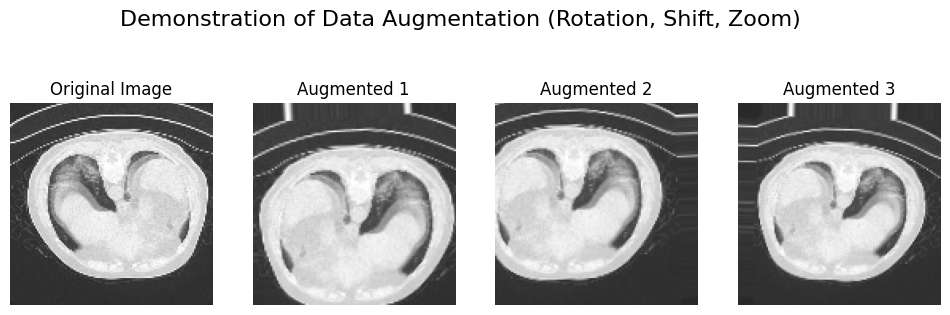

In [6]:
# Select a random image
idx = np.random.randint(0, len(X_train))
sample_img = X_train[idx]
sample_mask = y_train[idx]
    
# Prepare dimensions for the generator
sample_img_exp = np.expand_dims(sample_img, 0)
sample_mask_exp = np.expand_dims(sample_mask, 0)
    
# Generate 3 augmented versions
aug_iter = combine_generator(
    image_datagen.flow(sample_img_exp, batch_size=1, seed=1),
    mask_datagen.flow(sample_mask_exp, batch_size=1, seed=1)
)
    
plt.figure(figsize=(12, 4))
    
# Display Original Image
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(sample_img)
plt.axis('off')
    
# Display Augmented Versions
for i in range(3):
        aug_img, aug_mask = next(aug_iter)
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented {i+1}")
        plt.imshow(aug_img[0])
        plt.axis('off')
        
plt.suptitle("Demonstration of Data Augmentation (Rotation, Shift, Zoom)", fontsize=16)
plt.show()

## 6. Define Evaluation Metrics
Defining custom metrics (Dice Coefficient, Precision, Recall) to evaluate the segmentation performance.

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

## 7. Build U-Net Architecture
Constructing the U-Net model with Encoder, Decoder, and Skip Connections.

In [8]:
def build_unet():
    # Network input: Image with dimensions 128x128 and 3 RGB channels
    inputs = Input((128, 128, 3))

    # --- Contraction Path (Encoder) ---
    # Goal: Extract features and reduce image size
    
    # First Layer
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs) # Filter to extract features
    p1 = MaxPooling2D((2, 2))(c1) # Downsample the image by half

    # Second Layer
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Third Layer (Bottleneck)
    # This is the deepest point in the network containing the most concentrated features
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # --- Expansion Path (Decoder) ---
    # Goal: Upscale the image back and draw the mask
    
    # Fourth Layer (Upscaling)
    u4 = UpSampling2D((2, 2))(c3) # Upscale the image
    u4 = Concatenate()([u4, c2])  # (Skip Connection) Merge details from the second layer
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u4)

    # Fifth Layer (Final Upscaling)
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c1]) # Merge details from the first layer
    c5 = Conv2D(16, (3, 3), activation='relu', padding='same')(u5)

    # Output Layer
    # We used Sigmoid so the result is a probability (between 0 and 1) for each pixel
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet()
model.summary()

I0000 00:00:1765996109.685614      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765996109.686223      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         17 │ conv2d_4[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,209 (227.38 KB)

 Trainable params: 58,209 (227.38 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Compile and Train Model
Compiling the model with Adam optimizer and Binary Crossentropy loss. We use Callbacks for saving the best model and early stopping.

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', dice_coef, precision, recall])

# Use Callbacks to save the best model and avoid overfitting
callbacks = [
    ModelCheckpoint('model_unet.keras', verbose=1, save_best_only=True),
    EarlyStopping(patience=5, monitor='val_loss')
]

# Start Training
# Note: validation_data=(X_val, y_val) checks performance on validation set after each epoch
history = model.fit(train_generator, 
                    steps_per_epoch=len(X_train) // 16,
                    epochs=20, 
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/20


I0000 00:00:1765996115.128309      72 service.cc:148] XLA service 0x78af2800efb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765996115.129910      72 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765996115.129930      72 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765996115.609395      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/136 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.4022 - dice_coef: 0.0291 - loss: 0.7169 - precision: 0.0070 - recall: 0.4631 

I0000 00:00:1765996120.361197      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9408 - dice_coef: 0.0207 - loss: 0.2167 - precision: 4.8745e-04 - recall: 0.0307
Epoch 1: val_loss improved from inf to 0.06522, saving model to model_unet.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.9410 - dice_coef: 0.0208 - loss: 0.2160 - precision: 4.8456e-04 - recall: 0.0305 - val_accuracy: 0.9822 - val_dice_coef: 0.0964 - val_loss: 0.0652 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9802 - dice_coef: 0.1031 - loss: 0.0539 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss improved from 0.06522 to 0.05720, saving model to model_unet.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9802 - dice_coef: 0.1033 - loss: 0.0538 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9822 - val_dice_coef: 0.1736 - val_loss: 0.0572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
136/136 ━━━━━━━━

## 9. ROC Curve & AUC Score
Calculating and plotting the Receiver Operating Characteristic (ROC) curve to evaluate model sensitivity vs specificity.

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


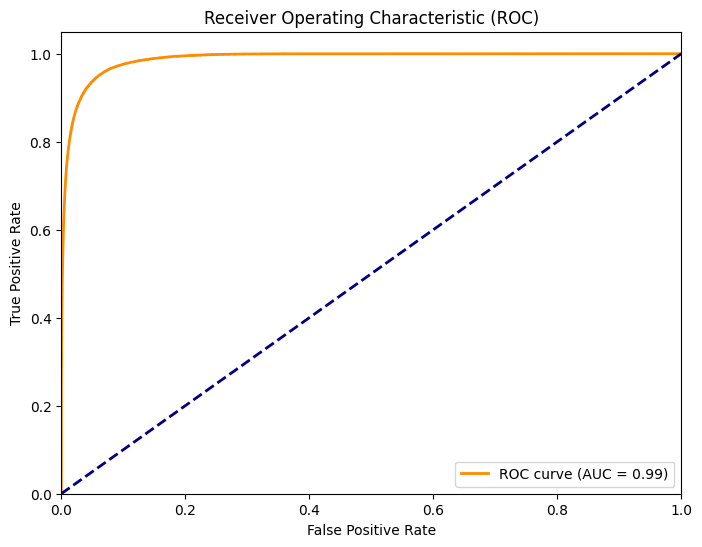

Final AUC Score: 0.9881


In [10]:
# Calculate predictions (Flattened for ROC)
y_pred = model.predict(X_test).ravel() 
y_test_flat = y_test.ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print Final AUC
print(f"Final AUC Score: {roc_auc:.4f}")

## 10. Training History Visualization
Plotting Accuracy and Loss curves for both Training and Validation sets to check for overfitting.

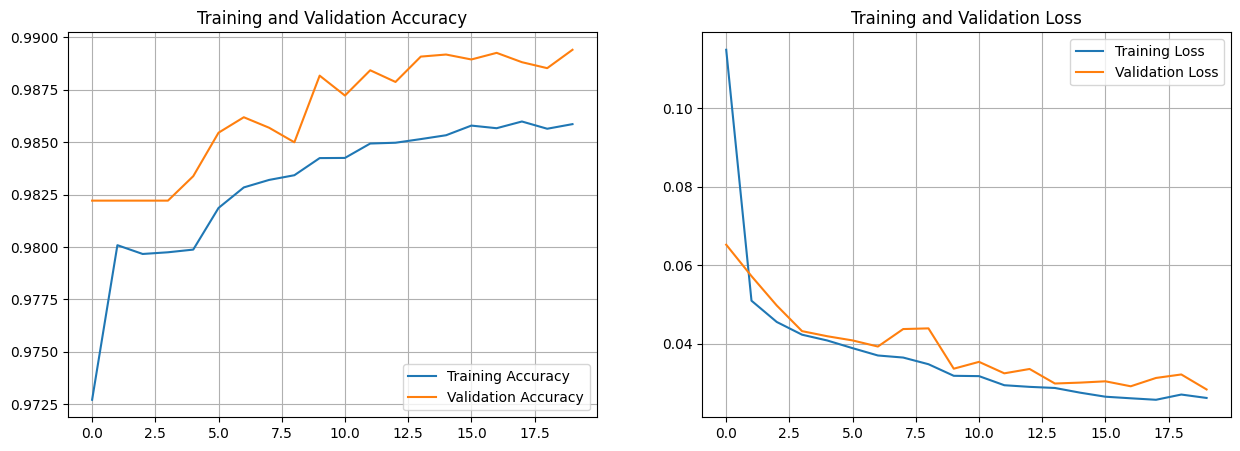

In [11]:
# Extract data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
    
# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
    
plt.show()

## 11. Final Evaluation on Test Set
Evaluating the model on the unseen Test data to get final metric scores.

In [12]:
# Calculate final values
# (Note: We use X_test which the model has never seen)
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss:      {results[0]:.4f}")
print(f"Test Accuracy:  {results[1]*100:.2f}%")
print(f"Test Precision: {results[2]:.4f}") 
print(f"Test Recall:    {results[3]:.4f}")

Test Loss:      0.0257
Test Accuracy:  99.09%
Test Precision: 0.5114
Test Recall:    0.8082


## 12. Detailed Classification Report & Confusion Matrix
Analyzing pixel-wise performance using a Confusion Matrix.


Classification Report:
              precision    recall  f1-score   support

  Background       0.99      1.00      1.00   4407850
      Lesion       0.80      0.50      0.61     64982

    accuracy                           0.99   4472832
   macro avg       0.90      0.75      0.80   4472832
weighted avg       0.99      0.99      0.99   4472832



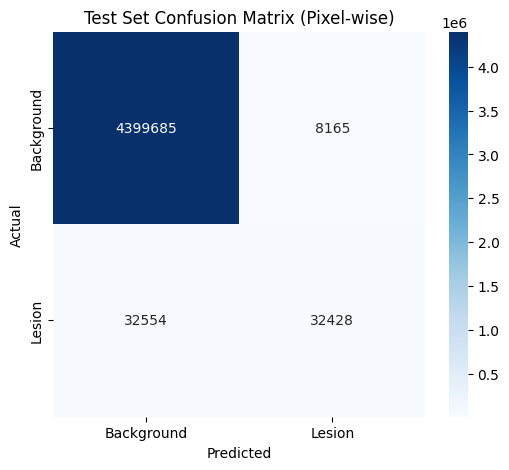

In [13]:
# Generate predictions for the whole Test set
y_pred_prob = model.predict(X_test, verbose=0)
    
# Convert predictions and masks to binary (0 and 1) and flatten them
y_pred_binary = (y_pred_prob > 0.5).astype(int).flatten()
y_test_binary = y_test.astype(int).flatten()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['Background', 'Lesion']))
    
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_binary, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Background', 'Lesion'], 
            yticklabels=['Background', 'Lesion'])
plt.title('Test Set Confusion Matrix (Pixel-wise)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 13. Identify Images with Lesions
Helper code to find indices of images that actually contain lesions (to avoid plotting empty black images).

In [14]:
# Search for images that have lesions (Mask is not fully black)
interesting_indices = []

for i in range(len(y_test)):
    # If sum of mask pixels > 0, it contains a lesion
    if np.sum(y_test[i]) > 0:
        interesting_indices.append(i)

# Print first 30 found indices
print('Indices of images containing lesions:')
print(interesting_indices[:30])

Indices of images containing lesions:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [15]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_flat.astype(int), (y_pred > 0.5).astype(int)))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   4407850
           1       0.80      0.50      0.61     64982

    accuracy                           0.99   4472832
   macro avg       0.90      0.75      0.80   4472832
weighted avg       0.99      0.99      0.99   4472832



## 14. Visualize Model Predictions
Comparing Original Image, True Mask, and AI Predicted Mask for specific samples.

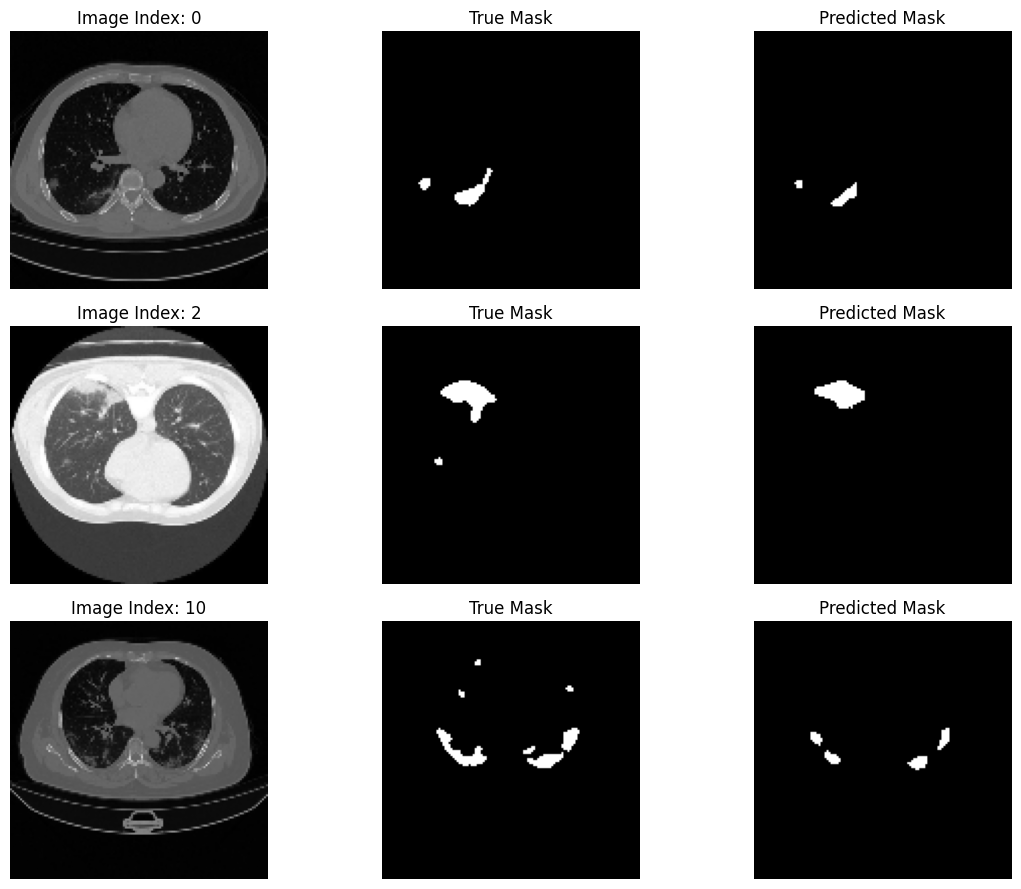

In [16]:
# Choose specific indices to display
indices_list = [0, 2, 10] # You can change these based on the output of the previous cell
num_samples = len(indices_list)
    
# Setup plot area
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))
    
# Handle case of single sample
if num_samples == 1:
    axes = np.expand_dims(axes, axis=0)

for i, idx in enumerate(indices_list):
        # 1. Prepare Data
        img = X_test[idx]
        true_mask = y_test[idx].squeeze()
        
        # 2. Predict
        input_img = np.expand_dims(img, axis=0)
        pred_prob = model.predict(input_img, verbose=0)[0]
        pred_mask = (pred_prob > 0.5).astype(np.float32).squeeze()
        
        # 3. Plotting
        # Original Image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image Index: {idx}")
        axes[i, 0].axis('off')
        
        # True Mask
        axes[i, 1].imshow(true_mask, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis('off')
        
        # AI Prediction
        axes[i, 2].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()